In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, accuracy_score, roc_curve, precision_recall_fscore_support, classification_report

from sklearn.datasets import make_classification, make_circles, make_moons

import altair as alt
#alt.renderers.enable('notebook')
alt.renderers.enable('default')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
X,y = make_classification(1000)
X_moon,y_moon = make_moons(1000)
X_circle,y_circle = make_circles(1000)
moon = pd.DataFrame( { 'x' : X_moon[:,0], 'y' : X_moon[:,1], 'label' : y_moon } )
circle = pd.DataFrame( { 'x' : X_circle[:,0], 'y' : X_circle[:,1], 'label' : y_circle })

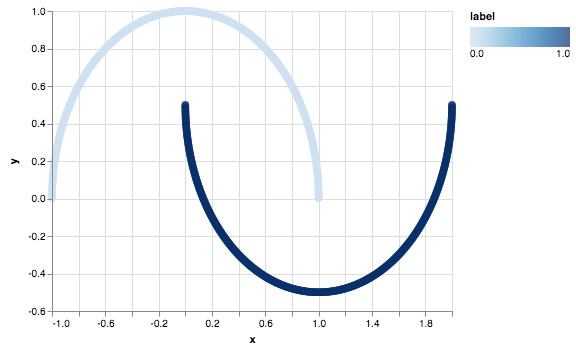

In [3]:
chart = alt.Chart(moon).mark_circle(size=60).encode(
        x='x',
        y='y',
        color='label',
        tooltip=['x','y','label'])
chart

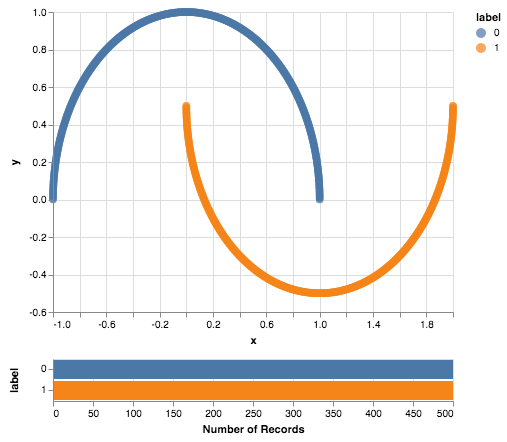

In [4]:
brush = alt.selection(type='interval')
chart = alt.Chart().mark_circle(size=60).encode(
        x='x:Q',
        y='y:Q',
        color='label:N',
        tooltip=['x', 'y', 'label']
).add_selection(brush)

bars = alt.Chart().mark_bar().encode(
    y='label:N',
    color='label:N',
    x='count(label):Q'
).transform_filter(
    brush
)
alt.vconcat(chart,bars,data=moon)

In [5]:
X_moon_train,X_moon_test,y_moon_train,y_moon_test = train_test_split(moon[['x','y']],moon['label'], test_size=0.2)
clf = LogisticRegression().fit(X_moon_train,y_moon_train)
print(classification_report(y_moon_test,clf.predict(X_moon_test)))

             precision    recall  f1-score   support

          0       0.86      0.91      0.89        94
          1       0.92      0.87      0.89       106

avg / total       0.89      0.89      0.89       200



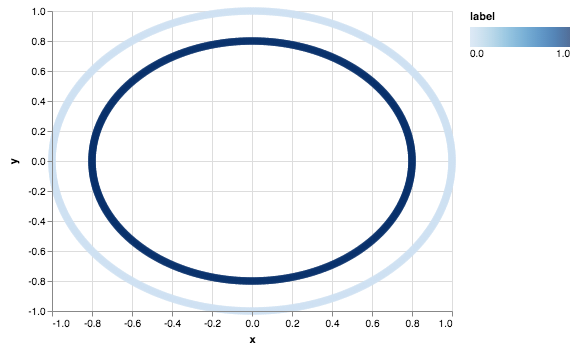

In [6]:
chart = alt.Chart(circle).mark_circle(size=60).encode(
        x='x',
        y='y',
        color='label',
        tooltip=['x','y','label'])#.facet(column='label:N')
chart

In [7]:
X_circle_train,X_circle_test,y_circle_train,y_circle_test = train_test_split(circle[['x','y']],circle['label'], test_size=0.5)
clf = LogisticRegression().fit(X_circle_train,y_circle_train)
print(classification_report(y_circle_test,clf.predict(X_circle_test)))

             precision    recall  f1-score   support

          0       0.60      0.25      0.35       261
          1       0.50      0.82      0.62       239

avg / total       0.55      0.52      0.48       500



Here, I split the training once more into two:
* Train the kernel approximator
* Train the linear model
This is important to avoid overfitting.

In [8]:
X_train_kernel,X_train_lr,y_train_kernel,y_train_lr = train_test_split(X_circle_train, y_circle_train, test_size=0.5)
kernel = RandomForestClassifier()
encoder = OneHotEncoder()
clf = LogisticRegression()
kernel.fit(X_train_kernel, y_train_kernel)
applied_data = kernel.apply(X_train_kernel)
encoder.fit(kernel.apply(X_train_kernel))
clf.fit( encoder.transform( kernel.apply(X_train_lr)), y_train_lr )
expanded = encoder.transform(kernel.apply(X_circle_test))
print(classification_report(y_circle_test,clf.predict(expanded)))

             precision    recall  f1-score   support

          0       1.00      0.97      0.99       261
          1       0.97      1.00      0.99       239

avg / total       0.99      0.99      0.99       500



In [9]:
clf = RandomForestClassifier().fit(X_circle_train,y_circle_train)
print(classification_report(y_circle_test,clf.predict(X_circle_test)))

             precision    recall  f1-score   support

          0       1.00      0.96      0.98       261
          1       0.96      1.00      0.98       239

avg / total       0.98      0.98      0.98       500



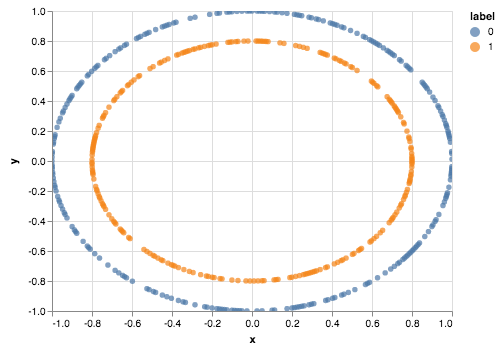

In [10]:
chart = alt.Chart( pd.merge(X_circle_test,
                            pd.DataFrame({'label':y_circle_test}),
                            left_index=True,right_index=True) ).mark_circle().encode(
                   x='x',
                   y='y',
                   color='label:N').interactive()
chart

In [41]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
rbfkernel = RBFSampler(gamma=1, random_state=1)
transformed_data = rbfkernel.fit_transform(X_circle_train)
clf = SGDClassifier().fit(transformed_data,y_circle_train)   
print( classification_report(y_circle_test, clf.predict(rbfkernel.transform(X_circle_test))) )

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       261
          1       1.00      1.00      1.00       239

avg / total       1.00      1.00      1.00       500



/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


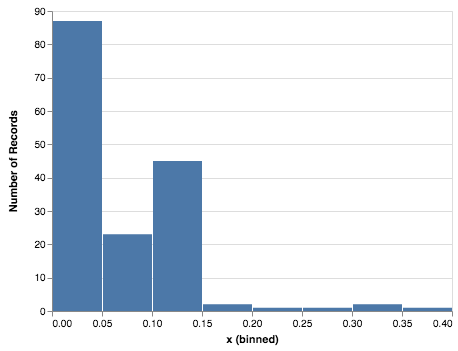

In [11]:
features = expanded.todense()
freq = np.array(expanded.todense()).sum(axis=0).astype(float)
freq = freq.clip(1,freq.max()).astype(float)
freq = freq/len(features)
bar = alt.Chart(pd.DataFrame({'x' : freq})).mark_bar().encode(
    alt.X('x', bin=True),
    alt.Y('count()')
)
bar

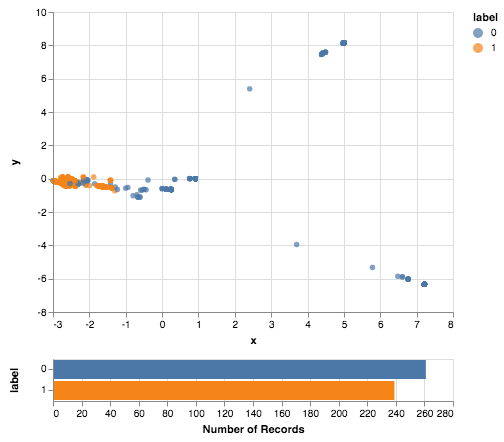

In [25]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomTreesEmbedding
from sklearn.preprocessing import StandardScaler

fweighted = np.multiply(features,1.0/freq)-1
svd = TruncatedSVD(n_components=2)
transformed_data = svd.fit_transform(StandardScaler().fit_transform(fweighted))
brush = alt.selection(type='interval')
data = pd.DataFrame({'x':transformed_data[:,0],'y':transformed_data[:,1],'label':y_circle_test})
chart = alt.Chart().mark_circle().encode(
                   x='x',
                   y='y',
                   color='label:N').add_selection(brush)
bars = alt.Chart().mark_bar().encode(
    y='label:N',
    color='label:N',
    x='count(label):Q'
).transform_filter(
    brush
).interactive()
alt.vconcat(chart,bars,data=data)

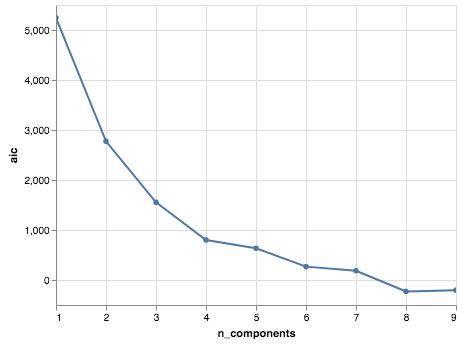

In [26]:
aics = []
for i in range(1,10):
    clusters = GaussianMixture(n_components=i)
    clusters.fit(transformed_data)
    aics.append( clusters.aic(transformed_data) )
chart = alt.Chart(pd.DataFrame({'aic':aics, 'n_components':range(1,10)})
                  ).mark_line(
                    point=True
                  ).encode(
                    y='aic',x='n_components', tooltip=['aic','n_components']
                  ).interactive()
chart

In [37]:
best = 2#aics.index(min(aics))+1
mixture = GaussianMixture(n_components=best)
mixture.fit(transformed_data)
print( classification_report(np.invert(y_circle_test.values.astype(bool)), mixture.predict(transformed_data)) )

             precision    recall  f1-score   support

      False       0.54      1.00      0.70       239
       True       1.00      0.21      0.34       261

avg / total       0.78      0.59      0.51       500



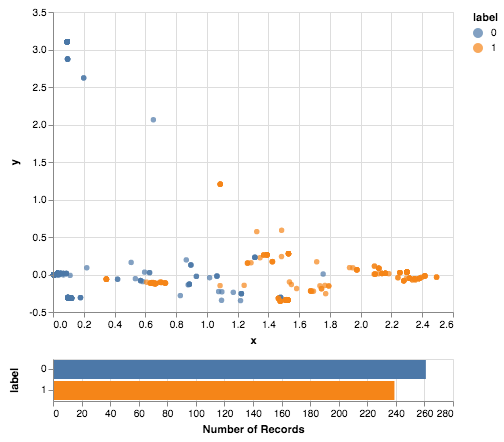

In [38]:
svd = TruncatedSVD(n_components=2)
transformed_data = svd.fit_transform(features)
brush = alt.selection(type='interval')
data = pd.DataFrame({'x':transformed_data[:,0],'y':transformed_data[:,1],'label':y_circle_test})
chart = alt.Chart().mark_circle().encode(
                   x='x',
                   y='y',
                   color='label:N').add_selection(brush)
bars = alt.Chart().mark_bar().encode(
    y='label:N',
    color='label:N',
    x='count(label):Q'
).transform_filter(
    brush
)
alt.vconcat(chart,bars,data=data)

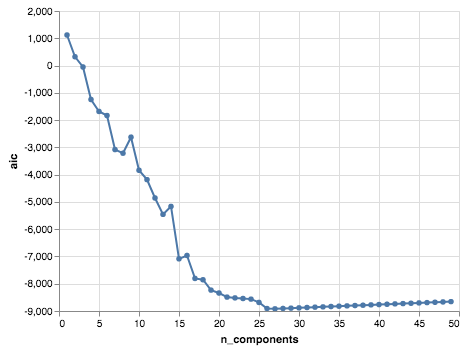

In [19]:
aics = []
for i in range(1,10):
    clusters = GaussianMixture(n_components=i)
    clusters.fit(transformed_data)
    aics.append( clusters.aic(transformed_data) )
chart = alt.Chart(pd.DataFrame({'aic':aics, 'n_components':range(1,10)})
                  ).mark_line(
                    point=True
                  ).encode(
                    y='aic',x='n_components', tooltip=['aic','n_components']
                  ).interactive()
chart

In [15]:
best = 2#aics.index(min(aics))+1
mixture = GaussianMixture(n_components=best)
mixture.fit(transformed_data)
print( classification_report(y_circle_test, mixture.predict(transformed_data)) )
print(mixture.predict(transformed_data))
print(y_circle_test)

             precision    recall  f1-score   support

          0       0.47      0.80      0.59       261
          1       0.00      0.00      0.00       239

avg / total       0.24      0.42      0.31       500

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

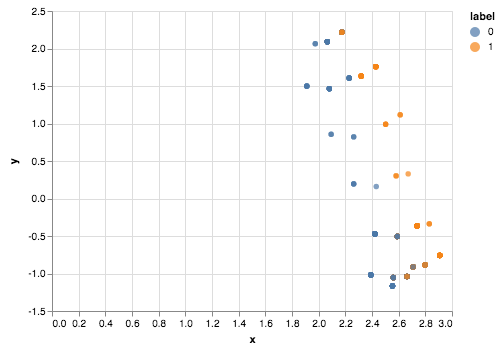

In [16]:
embedding = RandomTreesEmbedding(max_depth=1)
fdata = embedding.fit_transform(X_circle_test)
svd = TruncatedSVD(n_components=2)
transformed_data = svd.fit_transform(fdata)
chart = alt.Chart( pd.DataFrame({'x':transformed_data[:,0],'y':transformed_data[:,1],'label':y_circle_test}) ).mark_circle().encode(
                   x='x',
                   y='y',
                   color='label:N').interactive()
chart

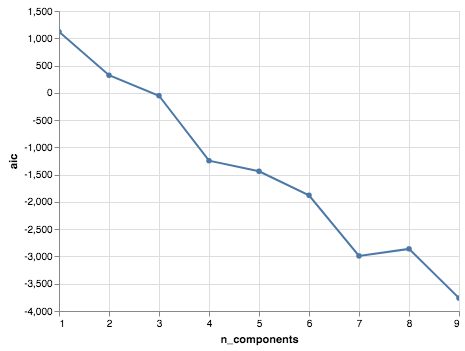

In [17]:
aics = []
for i in range(1,10):
    clusters = GaussianMixture(n_components=i)
    clusters.fit(transformed_data)
    aics.append( clusters.aic(transformed_data) )
chart = alt.Chart(pd.DataFrame({'aic':aics, 'n_components':range(1,10)})
                  ).mark_line(
                    point=True
                  ).encode(
                    y='aic',x='n_components', tooltip=['aic','n_components']
                  ).interactive()
chart

In [18]:
best = 2#aics.index(min(aics))+1
mixture = GaussianMixture(n_components=best)
mixture.fit(transformed_data)
print( classification_report(y_circle_test, mixture.predict(transformed_data)) )
print(mixture.predict(transformed_data))
print(y_circle_test)

             precision    recall  f1-score   support

          0       0.52      0.67      0.58       261
          1       0.47      0.32      0.38       239

avg / total       0.49      0.50      0.48       500

[1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 1 1 0 1 1 0 1 0 0 0
 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0
 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1
 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0
 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0
 0 0 0 0 1 1 0 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 1
 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1
 0 1 1 0 1 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1
 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 